In [1]:
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.metrics import roc_curve, roc_auc_score, auc
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load and preprocess
df = pd.read_csv("DATASET_clean.csv")
X = df.drop(columns=["SEQN", "a1c_test"])
y = df["a1c_test"]
cat_cols = ['ALQ111', 'SMQ020', 'DPQ010', 'DPQ040', 'DPQ050', 'DPQ060', 'DMDBORN', 'DMDEDUC', 'DMDMARTX']
X[cat_cols] = X[cat_cols].astype("category")

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [3]:
model1 = SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42)
model1.fit(X_train_scaled, y_train)

# Evaluation
y_pred = model1.predict(X_test_scaled)
print("🔹 Balanced Linear SVM")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

y_proba = model1.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)


🔹 Balanced Linear SVM
Accuracy: 0.7116477272727273
RMSE: 0.5369844250323027
Confusion Matrix:
 [[442 182]
 [ 21  59]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.71      0.81       624
           1       0.24      0.74      0.37        80

    accuracy                           0.71       704
   macro avg       0.60      0.72      0.59       704
weighted avg       0.87      0.71      0.76       704



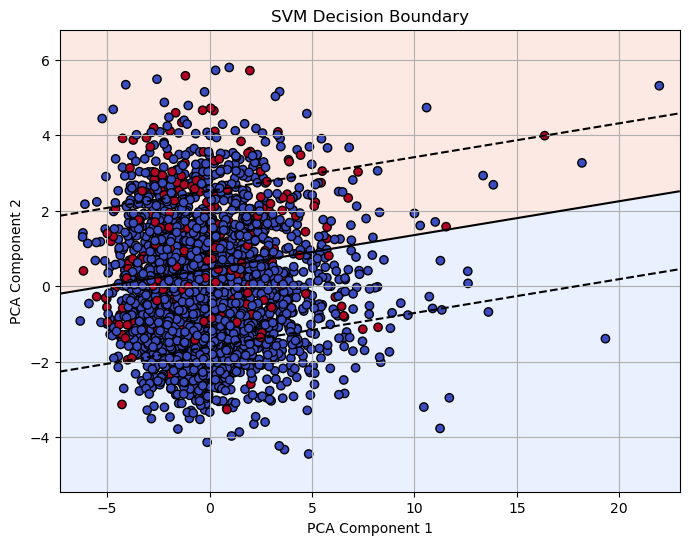

In [4]:
# Visualization with PCA
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X_train_scaled)
model_vis = SVC(kernel='linear', class_weight='balanced')
model_vis.fit(X_vis, y_train)

xx, yy = np.meshgrid(
    np.linspace(X_vis[:, 0].min()-1, X_vis[:, 0].max()+1, 300),
    np.linspace(X_vis[:, 1].min()-1, X_vis[:, 1].max()+1, 300)
)
Z = model_vis.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=sorted([Z.min(), 0, Z.max()]), alpha=0.2, cmap="coolwarm")
plt.contour(xx, yy, Z, levels=[-1, 0, 1], linestyles=["--", "-", "--"], colors="k")
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_train, cmap='coolwarm', edgecolors='k')
plt.title("SVM Decision Boundary")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

In [5]:
cv_scores = cross_val_score(model1, X_train_scaled, y_train, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean:", cv_scores.mean(), "Std Dev:", cv_scores.std())

train_pred = model1.predict(X_train_scaled)
test_pred = model1.predict(X_test_scaled)

print("Train Accuracy:", accuracy_score(y_train, train_pred))
print("Test Accuracy: ", accuracy_score(y_test, test_pred))


Cross-validation scores: [0.70744681 0.70159858 0.70870337 0.68916519 0.71225577]
Mean: 0.703833944295378 Std Dev: 0.00809766196989821
Train Accuracy: 0.7116477272727273
Test Accuracy:  0.7116477272727273


In [6]:
param_grid = {'C': [.1,1,3,5,7,9]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    SVC(kernel='linear', class_weight='balanced', probability=True),
    param_grid,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1
)
grid.fit(X_train_scaled, y_train)

# Evaluation
model11 = grid.best_estimator_
y_pred = model11.predict(X_test_scaled)
print("\n🔹 GridSearch SMOTE Linear SVM")
print("Best Params:", grid.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("MSE:", mean_squared_error(y_test, y_pred, squared=True))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


y_proba = model11.predict_proba(X_test_scaled)[:, 1]
fpr1, tpr1, thresholds = roc_curve(y_test, y_proba)
roc_auc1 = auc(fpr1, tpr1)



🔹 GridSearch SMOTE Linear SVM
Best Params: {'C': 0.1}
Accuracy: 0.7073863636363636
RMSE: 0.5409377379732684
MSE: 0.29261363636363635
Confusion Matrix:
 [[441 183]
 [ 23  57]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.71      0.81       624
           1       0.24      0.71      0.36        80

    accuracy                           0.71       704
   macro avg       0.59      0.71      0.58       704
weighted avg       0.87      0.71      0.76       704



In [7]:
### MAKING BALANCED DATA

from imblearn.over_sampling import SMOTENC

X = df.drop(columns=["SEQN", "a1c_test"])
y = df["a1c_test"]

y = y.astype('category')
y.value_counts()

### MAKING BALANCED DATA 2
### PREPARE X columns to be categorized as factors

X_factors = ['ALQ111', 'SMQ020', 'DPQ010', 'DPQ040', 'DPQ050', 'DPQ060', 'DMDBORN', 'DMDEDUC', 'DMDMARTX']
X[X_factors] = X[X_factors].astype('category')

### SMOTE NC function
sm = SMOTENC(random_state=42, categorical_features= ['ALQ111', 'SMQ020', 'DPQ010', 'DPQ040', 'DPQ050', 'DPQ060', 'DMDBORN', 'DMDEDUC', 'DMDMARTX'])
X_res, y_res = sm.fit_resample(X, y)


### CONFIRM NEW COUNT
y_res.value_counts()
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_res)
X_res_scaled = sc.transform(X_res)


### balanced data is named X_res_scaled, and y_res
### split data into train and test
from sklearn.model_selection import train_test_split
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_res_scaled, y_res, test_size=0.2, random_state=50)

In [8]:
model2 = SVC(kernel='linear', probability=True, random_state=42)
model2.fit(X_train_scaled, y_train)

# Evaluation
y_pred = model2.predict(X_test_scaled)
print("🔹 SMOTE Linear SVM")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

y_proba = model2.predict_proba(X_test_scaled)[:, 1]
fpr_1, tpr_1, thresholds = roc_curve(y_test, y_proba)
roc_auc_1 = auc(fpr_1, tpr_1)


🔹 SMOTE Linear SVM
Accuracy: 0.789431545236189
RMSE: 0.4588773853262013
Confusion Matrix:
 [[470 173]
 [ 90 516]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.73      0.78       643
           1       0.75      0.85      0.80       606

    accuracy                           0.79      1249
   macro avg       0.79      0.79      0.79      1249
weighted avg       0.80      0.79      0.79      1249



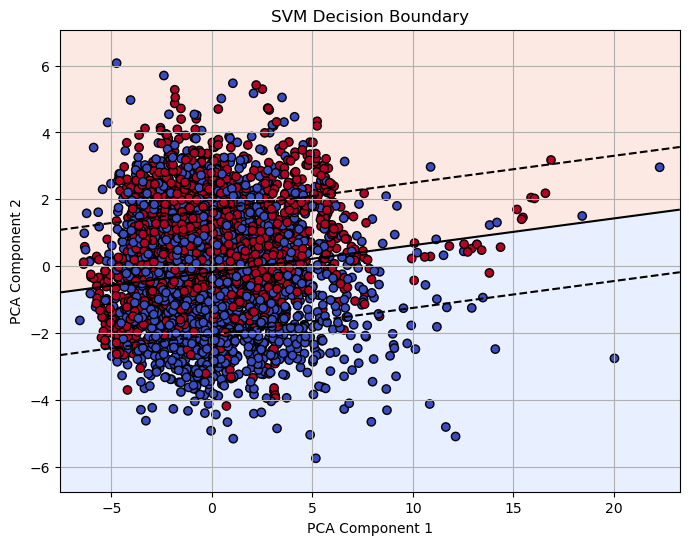

In [9]:
# Visualization with PCA
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X_train_scaled)
model_vis = SVC(kernel='linear')
model_vis.fit(X_vis, y_train)

xx, yy = np.meshgrid(
    np.linspace(X_vis[:, 0].min()-1, X_vis[:, 0].max()+1, 300),
    np.linspace(X_vis[:, 1].min()-1, X_vis[:, 1].max()+1, 300)
)
Z = model_vis.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=[Z.min(), 0, Z.max()], alpha=0.2, cmap="coolwarm")
plt.contour(xx, yy, Z, levels=[-1, 0, 1], linestyles=["--", "-", "--"], colors="k")
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_train, cmap='coolwarm', edgecolors='k')
plt.title("SVM Decision Boundary")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

In [10]:
cv_scores = cross_val_score(model2, X_train_scaled, y_train, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean:", cv_scores.mean(), "Std Dev:", cv_scores.std())

train_pred = model2.predict(X_train_scaled)
test_pred = model2.predict(X_test_scaled)

print("Train Accuracy:", accuracy_score(y_train, train_pred))
print("Test Accuracy: ", accuracy_score(y_test, test_pred))


Cross-validation scores: [0.78478478 0.80580581 0.81181181 0.78178178 0.77577578]
Mean: 0.791991991991992 Std Dev: 0.014161953300362302
Train Accuracy: 0.7951951951951952
Test Accuracy:  0.789431545236189


In [11]:
param_grid = {'C': [.1,1,3,5,7,9]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    SVC(kernel='linear', probability=True),
    param_grid,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1
)
grid.fit(X_train_scaled, y_train)

# Evaluation
model_best = grid.best_estimator_
y_pred = model_best.predict(X_test_scaled)
print("\n🔹 GridSearch SMOTE Linear SVM")
print("Best Params:", grid.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


y_proba = model_best.predict_proba(X_test_scaled)[:, 1]
fpr_smote, tpr_smote, thresholds = roc_curve(y_test, y_proba)
roc_auc_smote = auc(fpr_smote, tpr_smote)



🔹 GridSearch SMOTE Linear SVM
Best Params: {'C': 3}
Accuracy: 0.789431545236189
RMSE: 0.4588773853262013
Confusion Matrix:
 [[470 173]
 [ 90 516]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.73      0.78       643
           1       0.75      0.85      0.80       606

    accuracy                           0.79      1249
   macro avg       0.79      0.79      0.79      1249
weighted avg       0.80      0.79      0.79      1249



In [12]:
roc_auc_smote
print("RMSE:", mean_squared_error(y_test, y_pred, squared=True))

RMSE: 0.21056845476381106


In [13]:
support_vectors = model_best.support_vectors_
support_indices = model_best.support_
decision_values = model_best.decision_function(support_vectors)

# Convert labels to ±1
y_support = y_train.values.ravel()[support_indices].astype(int)
y_support = np.where(y_support == 0, -1, 1)

# Signed margins: y * f(x)
signed_margin = y_support * decision_values

# Classification of support vectors
correctly_classified_sv = np.sum(signed_margin >= 0)
misclassified_sv = np.sum(signed_margin < 0)

# Output
print(f"🔎 Total Support Vectors: {len(support_vectors)}")
print(f"✅ Correctly Classified Support Vectors: {correctly_classified_sv}")
print(f"❌ Misclassified Support Vectors: {misclassified_sv}")


🔎 Total Support Vectors: 2558
✅ Correctly Classified Support Vectors: 1534
❌ Misclassified Support Vectors: 1024


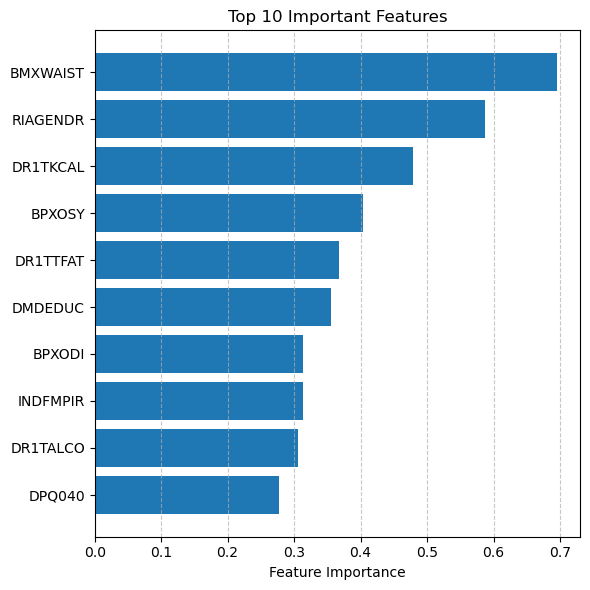

In [14]:
importances = np.abs(model_best.coef_[0])
importances

feature_names = X.columns.tolist()


indices = np.argsort(importances)[::-1]  # Descending order

top_n = 10
indices = np.argsort(importances)[-top_n:][::-1]  # top N in descending order

# Plot
plt.figure(figsize=(6, 6))
plt.barh(range(top_n), importances[indices], align='center')
plt.yticks(range(top_n), [feature_names[i] for i in indices])
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features")
plt.gca().invert_yaxis()  # most important at top
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

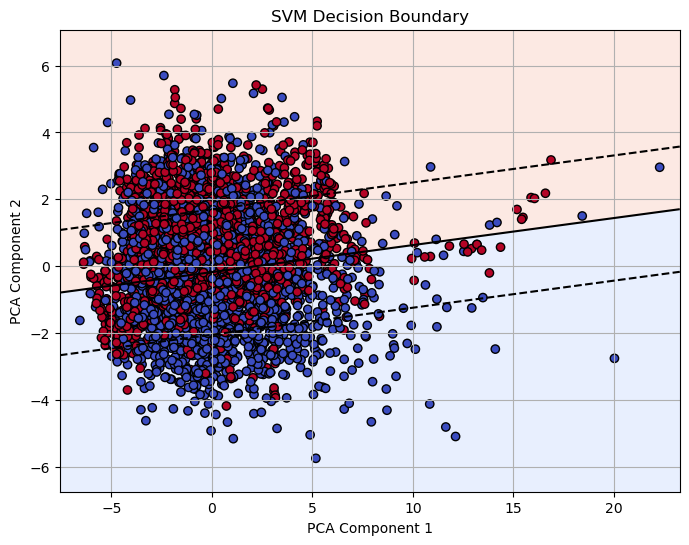

In [15]:
# Visualization using PCA
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X_train_scaled)
model_vis = SVC(kernel='linear', **grid.best_params_)
model_vis.fit(X_vis, y_train)

xx, yy = np.meshgrid(
    np.linspace(X_vis[:, 0].min()-1, X_vis[:, 0].max()+1, 300),
    np.linspace(X_vis[:, 1].min()-1, X_vis[:, 1].max()+1, 300)
)
Z = model_vis.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=[Z.min(), 0, Z.max()], alpha=0.2, cmap="coolwarm")
plt.contour(xx, yy, Z, levels=[-1, 0, 1], linestyles=["--", "-", "--"], colors="k")
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_train, cmap='coolwarm', edgecolors='k')
plt.title("SVM Decision Boundary")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()



In [16]:
w = model_vis.coef_[0]
b = model_vis.intercept_[0]

# Slope and intercept
slope = -w[0] / w[1]
intercept = -b / w[1]

print(f"🧮 Decision Boundary Equation:")
print(f"  x₂ = {slope:.4f} * x₁ + {intercept:.4f}")

🧮 Decision Boundary Equation:
  x₂ = 0.0809 * x₁ + -0.1810


In [17]:
cv_scores = cross_val_score(model_best, X_train_scaled, y_train, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean:", cv_scores.mean(), "Std Dev:", cv_scores.std())

train_pred = model_best.predict(X_train_scaled)
test_pred = model_best.predict(X_test_scaled)

print("Train Accuracy:", accuracy_score(y_train, train_pred))
print("Test Accuracy: ", accuracy_score(y_test, test_pred))


Cross-validation scores: [0.78478478 0.80580581 0.81081081 0.78278278 0.77577578]
Mean: 0.791991991991992 Std Dev: 0.013745460575593126
Train Accuracy: 0.794994994994995
Test Accuracy:  0.789431545236189


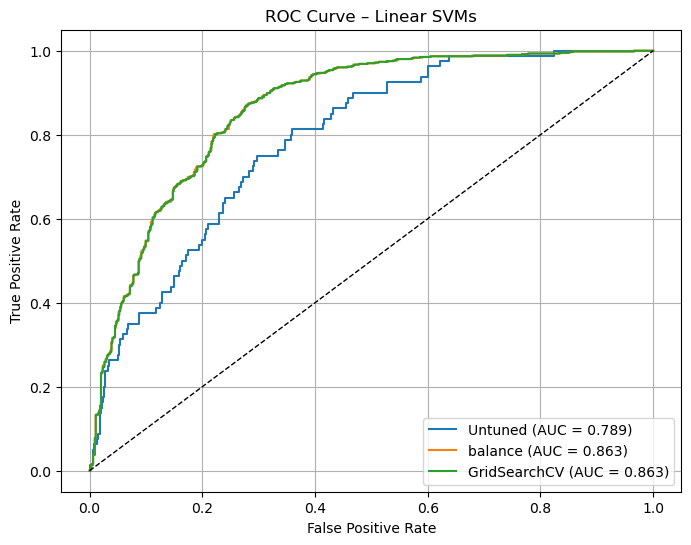

In [18]:

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Untuned (AUC = {roc_auc:.3f})')
plt.plot(fpr_1, tpr_1, label=f'balance (AUC = {roc_auc_1:.3f})')
plt.plot(fpr_smote, tpr_smote, label=f'GridSearchCV (AUC = {roc_auc_smote:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.title("ROC Curve – Linear SVMs")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
